# Setup -- Import

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


pl.Config.set_tbl_hide_dataframe_shape(True)
pl.Config.set_fmt_str_lengths(60)
pl.Config.set_tbl_rows(25)

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_drive_path = '/content/drive/MyDrive/cursus/uc'

In [4]:
model_tracking = pd.DataFrame(columns=[
    'Model',
    'Hyperparameters',
    'Preprocessing',
    'Training Accuracy',
    'Validation Accuracy',
    'Test Accuracy',
    'Comments'
])

model_tracking

,Model,Hyperparameters,Preprocessing,Training Accuracy,Validation Accuracy,Test Accuracy,Comments


In [5]:
def add_entry(new_entry: dict) -> None:
    return pd.concat([model_tracking, new_entry], ignore_index=True)

# Data Exploration

In [6]:
intents_test_path = f"{dataset_drive_path}/data/intents_test.csv"
intents_train_path = f"{dataset_drive_path}/data/intents_train.csv"
intents_train = pl.read_csv(intents_train_path, new_columns=['intent', 'label'])
intents_test = pl.read_csv(intents_test_path, new_columns=['intent'])

In [7]:
intents_train

intent,label
str,str
"""Carbon fiber bike""","""Bike Types"""
"""budget bikes""","""Bike Types"""
"""professional bikes""","""Bike Types"""
"""bikes for men""","""Bike Types"""
"""bikes for women""","""Bike Types"""
"""bikes for kids""","""Bike Types"""
"""I'm looking for a bike for my son""","""Bike Types"""
"""Budget Bikes for Road and Trail""","""Bike Types"""
"""light-weighted bikes""","""Bike Types"""


In [8]:
intents_test

intent
str
"""Do I need to replace my helmet?"""
"""My bike was stolen what should I do?"""
"""What types or choices of bikes do I have in your store?"""
"""Do you rent bikes?"""
"""I'm a student and I'm doing a project..."""
"""Can I bring my dog into your shop?"""
"""Do you match prices?"""
"""can I get an appointment tomorrow?"""
"""How much to repair my bike?"""


To understand the types of intents present in the training data, we can examine the unique values in the intent column.

In [9]:
import seaborn as sns

def plot_intent_distribution(data):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data.to_pandas(), x='label', palette='Set2')
    plt.xticks(rotation=45)
    plt.xlabel('Intent Label')
    plt.ylabel('Count')
    plt.title('Distribution of Intent Labels')
    plt.show()

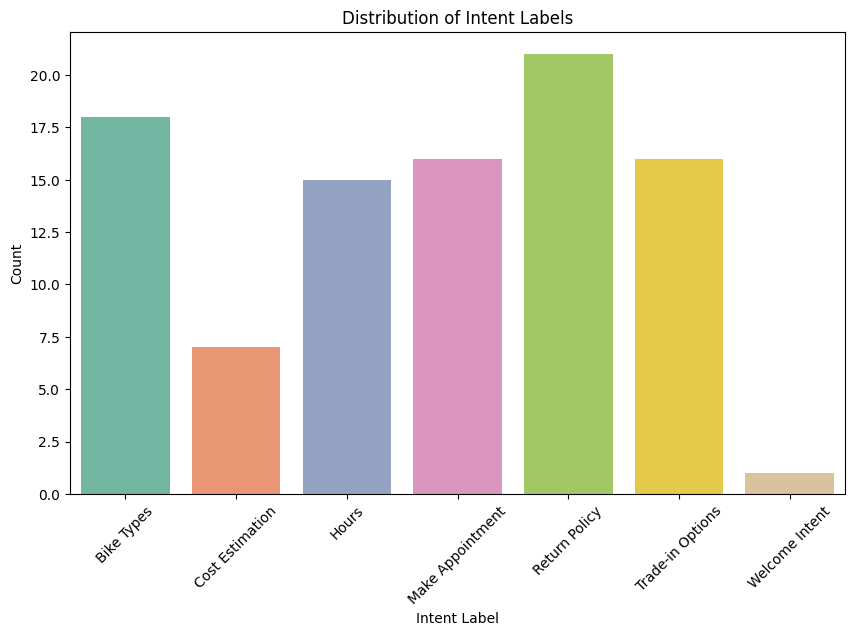

In [10]:
plot_intent_distribution(intents_train)

In [11]:
import re
from collections import Counter, OrderedDict

def tokenize(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = text.split()
    return tokenized

In [12]:
from sklearn.model_selection import train_test_split

intents_train, intents_valid = train_test_split(intents_train, test_size=0.2, random_state=1)

In [13]:
intents_train

intent,label
str,str
"""What are your hours?""","""Hours"""
"""My bike is broken""","""Make Appointment"""
"""Can I setup an appointment to ""","""Make Appointment"""
"""price of adjusting the seat""","""Cost Estimation"""
"""I want to get a new bike, can you take my old one?""","""Trade-in Options"""
"""hello""","""Welcome Intent"""
"""business hours""","""Hours"""
"""when do you close?""","""Hours"""
"""I'd like to schedule an appointment for ""","""Make Appointment"""


In [14]:
intents_valid

intent,label
str,str
"""The seat is too high for me. Need to ""","""Make Appointment"""
"""weekday schedule""","""Hours"""
"""appointment""","""Make Appointment"""
"""I want to trade in my bike""","""Trade-in Options"""
"""upgrade my old bike""","""Trade-in Options"""
"""I need to come in for a ""","""Make Appointment"""
"""Can I get full refund?""","""Return Policy"""
"""tune-ups""","""Make Appointment"""
"""I need to get rid of an old bike.""","""Trade-in Options"""


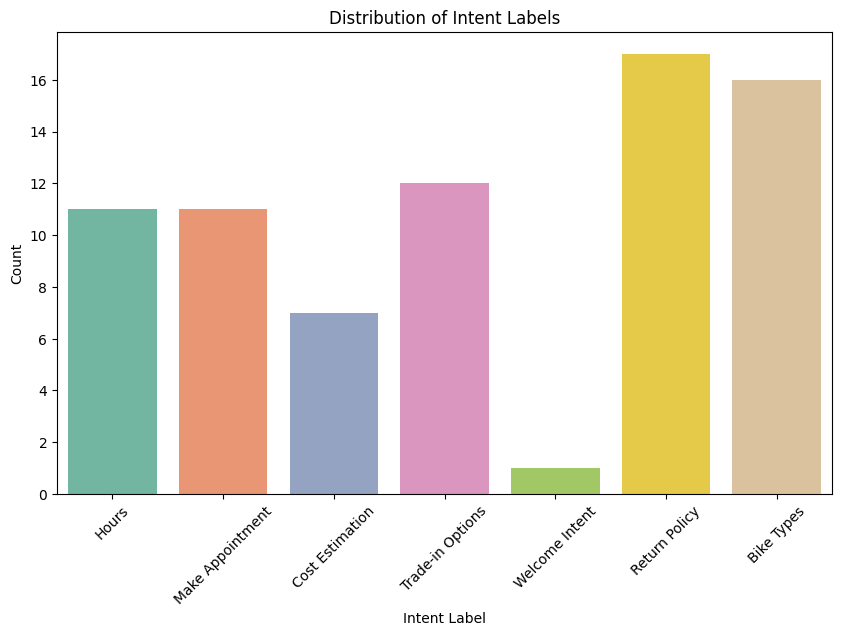

In [15]:
plot_intent_distribution(intents_train)

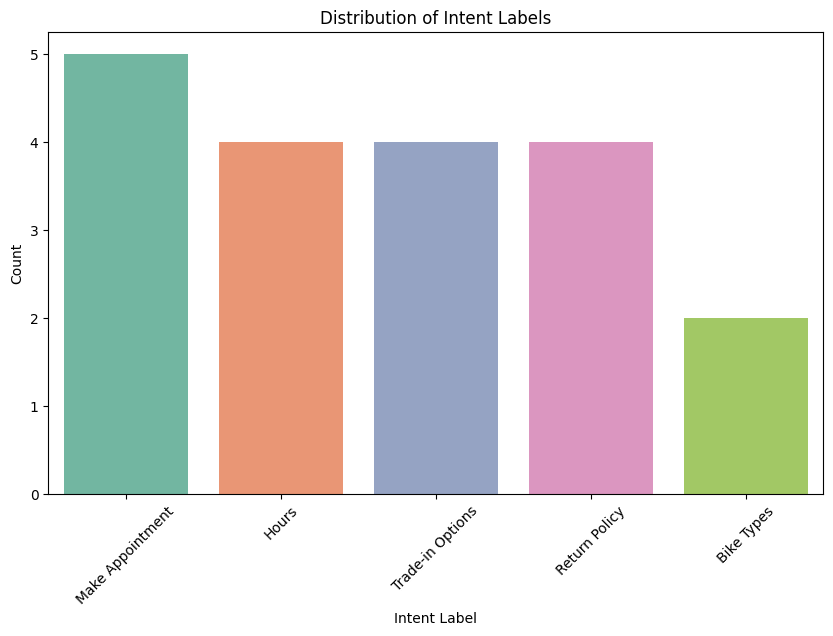

In [16]:
plot_intent_distribution(intents_valid)

In [30]:
class Vocabulary:
    def __init__(self, token_counts, pad_token="<pad>", unk_token="<unk>"):
        self.token_counts = token_counts
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.stoi = {}  # string to index
        self.itos = []  # index to string

        self.build_vocab()

    def build_vocab(self):
        self.stoi[self.pad_token] = 0
        self.stoi[self.unk_token] = 1
        self.itos.append(self.pad_token)
        self.itos.append(self.unk_token)

        for token, count in self.token_counts.items():
            if token not in self.stoi:
                idx = len(self.itos)
                self.stoi[token] = idx
                self.itos.append(token)

    def get_itos(self, indices):
        return [self.itos[idx] for idx in indices]

    def __getitem__(self, token):
        return self.stoi.get(token, 1)  # return unk_token index if token not found

    def __len__(self):
        return len(self.itos)

In [31]:
token_counts = Counter()
for sample in intents_train.iter_rows():
    tokens = tokenize(sample[0])
    token_counts.update(tokens)


sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ord_dict = OrderedDict(sorted_by_freq_tuples)
print('Vocab-size:', len(token_counts))

vocab = Vocabulary(token_counts)

print([vocab[token] for token in ['this', 'is', 'an', 'example']])

Vocab-size: 126
[1, 8, 13, 1]


In [32]:
print([vocab[token] for token in ['can', 'i', 'return', 'the', 'bike', 'i', 'purchased']])

[10, 11, 47, 19, 7, 11, 1]


In [33]:
vocab.get_itos([10, 11, 47, 19, 7, 11, 1])

['can', 'i', 'return', 'the', 'bike', 'i', '<unk>']

In [34]:
s = set(list(intents_train['label']))
len_labels = len(s)
labels2idx = {i: j for j, i in enumerate(s)}
idx2labels = {j: i for j, i in enumerate(s)}

text_pipeline = lambda x: [vocab[token] for token in tokenize(x)]
label_pipeline = lambda x: labels2idx[x]

labels2idx

{'Return Policy': 0,
 'Hours': 1,
 'Make Appointment': 2,
 'Welcome Intent': 3,
 'Cost Estimation': 4,
 'Trade-in Options': 5,
 'Bike Types': 6}

In [35]:
import torch
from torch.utils.data import DataLoader, Dataset


def collate_batch(batch, test_set=False):
    label_list, text_list, lengths = [], [], []
    for sample in batch:
        if test_set == False:
            label_list.append(sample[1])
        processed_text = torch.tensor(text_pipeline(sample[0]), dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor([label_pipeline(l) for l in label_list], dtype=torch.int64)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(
        text_list, batch_first=True)
    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [36]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 24
train_dl = DataLoader([row for row in intents_train.iter_rows()], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader([row for row in intents_valid.iter_rows()], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader([row for row in intents_test.iter_rows()], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Using device: cuda


# Modeling

## RNN

In [37]:
from dataclasses import dataclass

@dataclass
class RNNConfig:

    vocab_size: int = len(vocab)
    embed_dim: int = 32
    rnn_hidden_dim: int = 32
    fc_hidden_dim: int = 64
    output_dim: int = len_labels
    dropout: float = 0.5


config = RNNConfig()

In [38]:
class RNN(nn.Module):

    def __init__(self, config: RNNConfig):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(config.vocab_size, config.embed_dim, padding_idx=0)
        self.rnn = nn.RNN(config.embed_dim, config.rnn_hidden_dim, batch_first=True)

        self.fc1 = nn.Linear(config.rnn_hidden_dim, config.fc_hidden_dim)
        self.dropout = nn.Dropout(config.dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(config.fc_hidden_dim, config.output_dim)

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        _, hidden = self.rnn(x)

        x = hidden[-1, :, :]  # or consider using the entire RNN output sequence
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [39]:
import torch.utils
import torch.utils.data


def train(
    dl_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    model: torch.nn.Module,
    ):

    """ Train the model on the training dataset """

    total_loss, total_acc = 0, 0

    model.train()
    for text, label, lengths in dl_loader:
        optimizer.zero_grad()
        preds = model(text, lengths)
        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(preds, 1)
        total_loss += loss.item() * label.size(0)
        total_acc += (preds  == label).float().sum().item()
    return total_loss / len(dl_loader.dataset), total_acc / len(dl_loader.dataset)

def evaluate(
    dl_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    model: torch.nn.Module,
    ):

    """ Evaluate the model on the validation or test set """

    total_loss, total_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for text, label, lengths in dl_loader:
            preds = model(text, lengths)
            loss = criterion(preds, label)
            _, preds = torch.max(preds, 1)
            total_acc += (preds == label).float().sum().item()
            total_loss += loss.item() * label.size(0)
        return total_loss / len(dl_loader.dataset), total_acc / len(dl_loader.dataset)

In [40]:
model = RNN(config).to(device)
print(model)

RNN(
  (embedding): Embedding(128, 32, padding_idx=0)
  (rnn): RNN(32, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=7, bias=True)
)


In [41]:
num_epochs = 30
lr = 0.001
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
torch.manual_seed(1)


for epoch in range(num_epochs):
    train_loss, train_acc = train(train_dl, optimizer, criteria, model)
    valid_loss, valid_acc = evaluate(valid_dl, criteria, model)
    print(f'Epoch {epoch}  train loss: {train_loss:.4f} train accuracy: {train_acc:.4f}',  f' valid loss: {valid_loss:.4f} valid accuracy: {valid_acc:.4f}')

Epoch 0  train loss: 1.9585 train accuracy: 0.1200  valid loss: 1.9009 valid accuracy: 0.3684
Epoch 1  train loss: 1.9299 train accuracy: 0.1467  valid loss: 1.8885 valid accuracy: 0.4211
Epoch 2  train loss: 1.8884 train accuracy: 0.2800  valid loss: 1.8767 valid accuracy: 0.4211
Epoch 3  train loss: 1.8888 train accuracy: 0.2933  valid loss: 1.8669 valid accuracy: 0.4211
Epoch 4  train loss: 1.8454 train accuracy: 0.3200  valid loss: 1.8572 valid accuracy: 0.4211
Epoch 5  train loss: 1.8358 train accuracy: 0.3200  valid loss: 1.8488 valid accuracy: 0.3684
Epoch 6  train loss: 1.7926 train accuracy: 0.5200  valid loss: 1.8391 valid accuracy: 0.3158
Epoch 7  train loss: 1.7615 train accuracy: 0.4000  valid loss: 1.8287 valid accuracy: 0.3158
Epoch 8  train loss: 1.7505 train accuracy: 0.4400  valid loss: 1.8174 valid accuracy: 0.2632
Epoch 9  train loss: 1.7661 train accuracy: 0.4000  valid loss: 1.8058 valid accuracy: 0.2632
Epoch 10  train loss: 1.7020 train accuracy: 0.5067  valid l

In [42]:
rnn_entry = pd.DataFrame([{
    'Model': 'RNN',
    'Hyperparameters': f"Learning rate: {lr}, Hidden units: {config.rnn_hidden_dim}",
    'Preprocessing': 'Lowercase, Remove punctuation',
    'Training Accuracy': f"{train_acc}",
    'Validation Accuracy': f"{valid_acc}",
    'Test Accuracy': 'N/A',
    'Comments': 'First attempt, overfitting observed'
}])

model_tracking = add_entry(rnn_entry)
model_tracking

,Model,Hyperparameters,Preprocessing,Training Accuracy,Validation Accuracy,Test Accuracy,Comments
0,RNN,"Learning rate: 0.001, Hidden units: 32","Lowercase, Remove punctuation",0.6533333333333333,0.2631578947368421,N/A,"First attempt, overfitting observed"


## LSTM

In [43]:
from dataclasses import dataclass

@dataclass
class LSTMConfig:

    vocab_size: int = len(vocab)
    embed_dim: int = 32
    lstm_hidden_dim: int = 100
    fc_hidden_dim: int = 32
    output_dim: int = len_labels
    dropout: float = 0.5


config = LSTMConfig()
config

LSTMConfig(vocab_size=128, embed_dim=32, lstm_hidden_dim=100, fc_hidden_dim=32, output_dim=7, dropout=0.5)

In [44]:
class LSTM(nn.Module):
    def __init__(self, config: RNNConfig):
        super().__init__()
        self.embedding = nn.Embedding(config.vocab_size, config.embed_dim, padding_idx=0)
        self.rnn = nn.LSTM(config.embed_dim, config.lstm_hidden_dim, batch_first=True, bidirectional=True)
        self.rnn_dropout = nn.Dropout(config.dropout)  # Add dropout to RNN output

        self.fc_layers = nn.Sequential(
            nn.Linear(config.lstm_hidden_dim*2, config.fc_hidden_dim),
            nn.Dropout(config.dropout),
            nn.ReLU(),
            nn.Linear(config.fc_hidden_dim, config.output_dim)
        )

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)

        _, (hidden, cell) = self.rnn(x)
        x = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        x = self.rnn_dropout(x)
        x = self.fc_layers(x)
        return x

In [45]:
model = LSTM(config).to(device)
print(model)

LSTM(
  (embedding): Embedding(128, 32, padding_idx=0)
  (rnn): LSTM(32, 100, batch_first=True, bidirectional=True)
  (rnn_dropout): Dropout(p=0.5, inplace=False)
  (fc_layers): Sequential(
    (0): Linear(in_features=200, out_features=32, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=7, bias=True)
  )
)


In [46]:
lr = 0.005
num_epochs = 30
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
torch.manual_seed(1)


for epoch in range(num_epochs):
    train_loss, train_acc = train(train_dl, optimizer, criteria, model)
    valid_loss, valid_acc = evaluate(valid_dl, criteria, model)
    print(f'Epoch {epoch}  train loss: {train_loss:.4f} train accuracy: {train_acc:.4f}',  f' valid loss: {valid_loss:.4f} valid accuracy: {valid_acc:.4f}')


Epoch 0  train loss: 1.9825 train accuracy: 0.1600  valid loss: 1.9000 valid accuracy: 0.2105
Epoch 1  train loss: 1.8691 train accuracy: 0.2000  valid loss: 1.8329 valid accuracy: 0.3684
Epoch 2  train loss: 1.7605 train accuracy: 0.2800  valid loss: 1.7350 valid accuracy: 0.3158
Epoch 3  train loss: 1.6032 train accuracy: 0.3200  valid loss: 1.6463 valid accuracy: 0.4737
Epoch 4  train loss: 1.3980 train accuracy: 0.4667  valid loss: 1.5835 valid accuracy: 0.4211
Epoch 5  train loss: 1.2271 train accuracy: 0.6000  valid loss: 1.4821 valid accuracy: 0.3684
Epoch 6  train loss: 1.0595 train accuracy: 0.6667  valid loss: 1.2779 valid accuracy: 0.5789
Epoch 7  train loss: 0.8866 train accuracy: 0.7733  valid loss: 1.3448 valid accuracy: 0.5263
Epoch 8  train loss: 0.7303 train accuracy: 0.8267  valid loss: 1.5949 valid accuracy: 0.3684
Epoch 9  train loss: 0.5095 train accuracy: 0.8933  valid loss: 1.4030 valid accuracy: 0.5263
Epoch 10  train loss: 0.4602 train accuracy: 0.9067  valid l

In [47]:
lstm_entry = pd.DataFrame([{
    'Model': 'LSTM',
    'Hyperparameters': f"Learning rate: {lr}, Hidden units: {config.lstm_hidden_dim}, Epochs: {num_epochs}",
    'Preprocessing': 'Lowercase, Remove punctuation',
    'Training Accuracy': f"{train_acc}",
    'Validation Accuracy': f"{valid_acc}",
    'Test Accuracy': 'N/A',
    'Comments': 'First attempt, overfitting observed'
}])

model_tracking = add_entry(lstm_entry)
model_tracking

,Model,Hyperparameters,Preprocessing,Training Accuracy,Validation Accuracy,Test Accuracy,Comments
0,RNN,"Learning rate: 0.001, Hidden units: 32","Lowercase, Remove punctuation",0.6533333333333333,0.2631578947368421,N/A,"First attempt, overfitting observed"
1,LSTM,"Learning rate: 0.005, Hidden units: 100, Epoch...","Lowercase, Remove punctuation",0.96,0.47368421052631576,N/A,"First attempt, overfitting observed"


## BERT

In [48]:
%%capture
! pip install datasets evaluate

In [49]:
import datasets

# Load the dataset
bikeshop_dataset = datasets.load_dataset("m0saan/bikeshop")

# Split the "train" split into training and validation sets
train_validation_ds = bikeshop_dataset["train"].train_test_split(train_size=0.8, seed=42)

# Rename the default "test" split to "validation"
validation_ds = train_validation_ds.pop("test")

# Create a DatasetDict to hold our splits
full_dataset = datasets.DatasetDict()

# Add the training, validation, and test sets to the DatasetDict
full_dataset["train"] = train_validation_ds["train"]
full_dataset["validation"] = validation_ds
full_dataset["test"] = bikeshop_dataset["test"]

# Print the full dataset dict
full_dataset

Generating train split:   0%|          | 0/1136 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/37 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 908
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 228
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 37
    })
})

In [50]:
s = set(full_dataset['train']['intent'])
len_labels = len(s)
labels2idx = {i: j for j, i in enumerate(s)}
idx2labels = {j: i for j, i in enumerate(s)}

text_pipeline = lambda x: [vocab[token] for token in tokenize(x)]
label_pipeline = lambda x: labels2idx[x]

labels2idx

{None: 0,
 'Return Policy': 1,
 'Hours': 2,
 'Make Appointment': 3,
 'Welcome Intent': 4,
 'Fallback Intent': 5,
 'Cost Estimation': 6,
 'Trade-in Options': 7,
 'Bike Types': 8}

In [51]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    tokenized_inputs = tokenizer(example["text"])
    labels = [label_pipeline(l) for l in example["intent"]]
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = full_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_datasets

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/908 [00:00<?, ? examples/s]

Map:   0%|          | 0/228 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'intent', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 908
    })
    validation: Dataset({
        features: ['text', 'intent', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 228
    })
    test: Dataset({
        features: ['text', 'intent', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 37
    })
})

In [52]:
tokenized_datasets = tokenized_datasets.remove_columns(["text", "intent"])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['input_ids', 'token_type_ids', 'attention_mask', 'labels']

In [53]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=37, collate_fn=data_collator
)

In [54]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 17]),
 'token_type_ids': torch.Size([8, 17]),
 'attention_mask': torch.Size([8, 17]),
 'labels': torch.Size([8])}

In [55]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len_labels)
model

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [56]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(2.1632, grad_fn=<NllLossBackward0>) torch.Size([8, 9])


In [57]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [58]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

342


In [59]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [60]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/342 [00:00<?, ?it/s]

In [61]:
import evaluate

metric = evaluate.load("precision")

model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute(average='micro')

{'precision': 0.9736842105263158}

In [62]:
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

predictions

tensor([1, 7, 8, 8, 5, 3, 6, 3, 6, 5, 6, 1, 6, 8, 6, 1, 1, 8, 2, 3, 7, 1, 2, 8,
        5, 2, 7, 5, 2, 1, 8, 1, 7, 2, 2, 3, 7], device='cuda:0')

In [63]:
predictions = predictions.cpu().numpy().tolist()
predictions[:10]

[1, 7, 8, 8, 5, 3, 6, 3, 6, 5]

In [65]:
fall_back = "I'm not sure I got that right. Can you try asking in a different way or provide more details?"
labels = [idx2labels[idx] if idx2labels[idx] != "Fallback Intent" else fall_back for idx in predictions]
pd.DataFrame(labels, full_dataset['test']['text'])

,0
Do I need to replace my helmet?,Return Policy
My bike was stolen what should I do?,Trade-in Options
What types or choices of bikes do I have in your store?,Bike Types
Do you rent bikes?,Bike Types
I'm a student and I'm doing a project...,I'm not sure I got that right. Can you try ask...
Can I bring my dog into your shop?,Make Appointment
Do you match prices?,Cost Estimation
can I get an appointment tomorrow?,Make Appointment
How much to repair my bike?,Cost Estimation
How do I know what size tire/tube I need?,I'm not sure I got that right. Can you try ask...


In [66]:
import pickle

# Save the model
with open('/content/drive/MyDrive/cursus/uc/model.pkl', 'wb') as f:
  pickle.dump(model, f)

# Make predictions
predictions = []
model.eval()
for batch in test_dataloader:
  batch = {k: v.to(device) for k, v in batch.items()}
  with torch.no_grad():
    outputs = model(**batch)

  logits = outputs.logits
  predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy().tolist())

# Save predictions to a CSV file
with open('/content/drive/MyDrive/cursus/uc/intents.csv', 'w') as f:
  f.write('intent\n')
  for prediction in predictions:
    f.write(f'{idx2labels[prediction]}\n')


In [67]:
pd.read_csv('/content/drive/MyDrive/cursus/uc/intents.csv')


,intent
0,Return Policy
1,Trade-in Options
2,Bike Types
3,Bike Types
4,Fallback Intent
5,Make Appointment
6,Cost Estimation
7,Make Appointment
8,Cost Estimation
9,Fallback Intent


## CNN

In [68]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder


df = bikeshop_dataset['train'].to_pandas()
df

,text,intent
0,Carbon fiber bike,Bike Types
1,budget bikes,Bike Types
2,professional bikes,Bike Types
3,bikes for men,Bike Types
4,bikes for women,Bike Types
...,...,...
1131,Can you describe the bike types you offer?,Bike Types
1132,What types of bikes do you carry?,Bike Types
1133,Can you list the available bike types?,Bike Types
1134,What types of bikes can I get?,Bike Types


In [70]:
max_len = df["text"].str.split().apply(len).max()
max_len

16

In [71]:
# Split the data into input (text) and labels
X = df["text"]
y = df["intent"]

# Create a label encoder to convert labels to numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Create a custom dataset class
class TextDataset(Dataset):
    def __init__(self, X, y, max_len):
        self.X = X
        self.y = y
        self.max_len = max_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X.iloc[idx]
        label = self.y[idx]

        # Tokenize the text
        tokens = text.split()

        # Pad the tokens to the maximum length
        tokens = tokens[:self.max_len]
        tokens += ["<PAD>"] * (self.max_len - len(tokens))

        # Convert tokens to numerical values
        tokens = [dataset_vocab.get(token, dataset_vocab["<UNK>"]) for token in tokens]

        # Convert to tensor
        tokens = torch.tensor(tokens)

        return tokens, torch.tensor(label)

# Create a vocabulary
dataset_vocab = {"<PAD>": 0, "<UNK>": 1}
for text in X:
    tokens = text.split()
    for token in tokens:
        if token not in dataset_vocab:
            dataset_vocab[token] = len(dataset_vocab)

In [72]:
print(dataset_vocab)

{'<PAD>': 0, '<UNK>': 1, 'Carbon': 2, 'fiber': 3, 'bike': 4, 'budget': 5, 'bikes': 6, 'professional': 7, 'for': 8, 'men': 9, 'women': 10, 'kids': 11, "I'm": 12, 'looking': 13, 'a': 14, 'my': 15, 'son': 16, 'Budget': 17, 'Bikes': 18, 'Road': 19, 'and': 20, 'Trail': 21, 'light-weighted': 22, 'good': 23, 'commuting': 24, 'daily': 25, 'usage': 26, 'Do': 27, 'you': 28, 'have': 29, 'beginner?': 30, 'cyclist.': 31, 'What': 32, 'options': 33, 'do': 34, 'in': 35, 'store': 36, 'me?': 37, 'Which': 38, 'is': 39, 'I': 40, 'want': 41, 'to': 42, 'purchase': 43, 'road': 44, 'what': 45, 'types': 46, 'of': 47, 'store?': 48, 'carry': 49, 'mountain': 50, 'bike?': 51, 'sell': 52, 'E-bikes?': 53, 'price': 54, 'changing': 55, 'seat': 56, 'adjusting': 57, 'the': 58, 'how': 59, 'much': 60, 'lubricate': 61, 'chain?': 62, 'How': 63, 'does': 64, 'it': 65, 'cost': 66, 'tire': 67, 'replacement': 68, 'charge': 69, 'tune-up?': 70, 'when': 71, 'open': 72, 'hours': 73, 'at': 74, 'evening,': 75, 'like': 76, '6pm?': 77, 

In [73]:
# Create the dataset and data loader
max_len = 32
dataset = TextDataset(X, y_encoded, max_len)
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [74]:
xb, yb = next(iter(train_loader))
xb.shape, yb.shape

(torch.Size([32, 32]), torch.Size([32]))

In [75]:
yb

tensor([7, 5, 4, 5, 7, 4, 2, 6, 5, 7, 4, 3, 4, 0, 7, 3, 7, 3, 4, 2, 1, 0, 5, 2,
        2, 3, 0, 1, 4, 7, 2, 4])

In [76]:
from dataclasses import dataclass, field

@dataclass
class CNNConfig:

    vocab_size: int = len(dataset_vocab)
    embed_dim: int = 100
    lstm_hidden_dim: int = 100
    fc_hidden_dim: int = 32
    output_dim: int = 9
    dropout: float = 0.5

    num_filters: int = 100
    num_channels: list = field(default_factory=lambda: [100, 100, 100])
    kernel_sizes: list = field(default_factory=lambda: [3, 4, 5]) # Use default_factory for mutable defaults


config = CNNConfig()
config

CNNConfig(vocab_size=999, embed_dim=100, lstm_hidden_dim=100, fc_hidden_dim=32, output_dim=9, dropout=0.5, num_filters=100, num_channels=[100, 100, 100], kernel_sizes=[3, 4, 5])

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def load_glove_embeddings(glove_path, word_to_index, embed_dim):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    embedding_matrix = np.zeros((len(word_to_index), embed_dim))
    for word, i in word_to_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return torch.tensor(embedding_matrix, dtype=torch.float32)

class CNNModel(nn.Module):
    def __init__(self, config: CNNConfig, glove_embeddings, **kwargs):
        super(CNNModel, self).__init__(**kwargs)
        self.embedding = nn.Embedding(config.vocab_size, config.embed_dim)

        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding.from_pretrained(glove_embeddings, freeze=True)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(config.num_channels), 9)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(config.num_channels, config.kernel_sizes):
            self.convs.append(nn.Conv1d(2 * config.embed_dim, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [78]:
glove_embeddings = load_glove_embeddings(f'{dataset_drive_path}/glove/glove.6B.100d.txt', dataset_vocab, config.embed_dim)

In [79]:
import torch.utils
import torch.utils.data


def train(
    dl_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    model: torch.nn.Module,
    ):

    """ Train the model on the training dataset """

    total_loss, total_acc = 0, 0

    model.train()
    for text, label in dl_loader:
        text = text.to(device)
        label = label.to(device)
        # import pdb; pdb.set_trace();
        optimizer.zero_grad()
        preds = model(text)
        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(preds, 1)
        total_loss += loss.item() * label.size(0)
        total_acc += (preds  == label).float().sum().item()
    return total_loss / len(dl_loader.dataset), total_acc / len(dl_loader.dataset)

def evaluate(
    dl_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    model: torch.nn.Module,
    ):

    """ Evaluate the model on the validation or test set """

    total_loss, total_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for text, label in dl_loader:
            preds = model(text)
            loss = criterion(preds, label)
            _, preds = torch.max(preds, 1)
            total_acc += (preds == label).float().sum().item()
            total_loss += loss.item() * label.size(0)
        return total_loss / len(dl_loader.dataset), total_acc / len(dl_loader.dataset)

In [83]:
cnn_model = CNNModel(config, glove_embeddings).to('cpu')

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

cnn_model.apply(init_weights)

print(cnn_model)

CNNModel(
  (embedding): Embedding(999, 100)
  (constant_embedding): Embedding(999, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=9, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)


In [84]:
lr, num_epochs = 0.001, 30
device = torch.device('cpu')
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=lr)


for epoch in range(num_epochs):
    train_loss, train_acc = train(train_loader, optimizer, criteria, cnn_model)
    print(f'Epoch {epoch}  train loss: {train_loss:.4f} train accuracy: {train_acc:.4f}')


Epoch 0  train loss: 2.2087 train accuracy: 0.1567
Epoch 1  train loss: 1.9677 train accuracy: 0.2438
Epoch 2  train loss: 1.8179 train accuracy: 0.3327
Epoch 3  train loss: 1.7415 train accuracy: 0.3759
Epoch 4  train loss: 1.5933 train accuracy: 0.4586
Epoch 5  train loss: 1.4978 train accuracy: 0.4991
Epoch 6  train loss: 1.3909 train accuracy: 0.5414
Epoch 7  train loss: 1.2620 train accuracy: 0.6136
Epoch 8  train loss: 1.1786 train accuracy: 0.6470
Epoch 9  train loss: 1.0600 train accuracy: 0.6937
Epoch 10  train loss: 0.9848 train accuracy: 0.7007
Epoch 11  train loss: 0.9099 train accuracy: 0.7342
Epoch 12  train loss: 0.8425 train accuracy: 0.7421
Epoch 13  train loss: 0.7723 train accuracy: 0.7711
Epoch 14  train loss: 0.7212 train accuracy: 0.8072
Epoch 15  train loss: 0.6590 train accuracy: 0.8143
Epoch 16  train loss: 0.6104 train accuracy: 0.8257
Epoch 17  train loss: 0.5633 train accuracy: 0.8495
Epoch 18  train loss: 0.5304 train accuracy: 0.8600
Epoch 19  train loss: 